In [1]:
import os     #hỗ trợ tương tác với hệ thống và thư mục
from keras.preprocessing.image import ImageDataGenerator   #để có thể sử dụng data augmentation trên ảnh.
from keras.preprocessing import image    #Cung cấp các công cụ để xử lý ảnh, như load_img và img_to_array.
import numpy as np  #dùng để làm việc với mảng và ma trận

# Đường dẫn đến thư mục chứa ảnh ban đầu
input_root_folder = "C:/Users/Admin/Desktop/PTHTTM/XLA"


# Đường dẫn đến thư mục để lưu ảnh mới được tạo ra
output_root_folder = "C:/Users/Admin/Desktop/PTHTTM/XLA_AGM"


# Tạo thư mục mới nếu nó chưa tồn tại
if not os.path.exists(output_root_folder):
    os.makedirs(output_root_folder) #tạo thu mục mới

# Số lần tạo ảnh mới (gấp 20 lần số ảnh hiện tại)
num_augmented_images = 20

# Đối tượng ImageDataGenerator để thực hiện augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  #quay ảnh -20 tới 20 độ
    width_shift_range=0.2,  #dịch ngang 1 khoảng ngẫu nhiên tối đã 20%
    height_shift_range=0.2,   #dọc ảnh 1 khoảng ngẫu nhiên tối đã 20%
    zoom_range=0.1, #phóng to hoặc thu nhỏ từ 0,9 tới 1,1
    horizontal_flip=True,   #lật ngang ảnh với xác suất 50%
)

# Lặp qua từng thư mục (label-tên của từng loại ảnh)
for label in ["dao", "gay bong chay", "luu dan", "sung luc", "sung truong", "bua", "kiem"]:
    input_label_folder = os.path.join(input_root_folder, label)
    output_label_folder = os.path.join(output_root_folder, label)

    # Tạo thư mục mới cho label nếu nó chưa tồn tại
    if not os.path.exists(output_label_folder):
        os.makedirs(output_label_folder)

    # Lặp qua từng ảnh trong thư mục hiện tại
    for filename in os.listdir(input_label_folder):
        #kiểm tra đúng định dạng hay không
        if filename.lower().endswith((".jpg", ".png",".jpeg")):
            input_image_path = os.path.join(input_label_folder, filename)
            img = image.load_img(input_image_path, target_size=(64, 64))  #Đọc ảnh từ đường dẫn và thay đổi kích thước về (64, 64) để phù hợp cho mạng nơ ron.
            img_array = image.img_to_array(img)      #Chuyển ảnh thành mảng NumPy để xử lý dễ dàng hơn.
            img_array = np.expand_dims(img_array, axis=0)   #Thêm một chiều để tạo batch.

            # Tạo ảnh mới bằng cách áp dụng augmentation
            #datagen.flow: Tạo một luồng ảnh mới từ ảnh gốc và augmentation.
            #batch_size=1: Xử lý từng ảnh một lần.
            #save_to_dir: Thư mục để lưu ảnh mới.
            #save_prefix: Tiền tố cho tên file lưu.
            #save_format: Định dạng của ảnh mới (ở đây là .jpg).
            #num_augmented_images: Số lần tạo ảnh mới, ở đây là gấp đôi số ảnh hiện tại.
            i = 0  #đêm số lần tạo ảnh
            #ý nghĩa lặp qua quá trình tạo ảnh mới thông qua augentaion và lưu vào thư mục mới
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_label_folder, save_prefix=filename.split('.')[0], save_format='jpg'):
                i += 1
                if i >= num_augmented_images:  #nếu vượt qua ngưỡng lượng ảnh đặt thì dừng
                    break

In [2]:
import matplotlib.pyplot as plt    #vẽ đồ thị và hiển thị hình ảnh.
#xây dựng và huấn luyện mô hình học máy.
import keras
import tensorflow as tf
import numpy as np  #xử lý mảng và dữ liệu số.
from keras.models import Sequential   #lớp Sequential từ Keras để xây dựng mô hình theo kiểu tuần tự.
#Import các lớp từ Keras để xây dựng các tầng trong mô hình
from keras.layers import Dense, Dropout, Flatten, Rescaling, RandomFlip, RandomRotation, RandomZoom, Conv2D, MaxPooling2D
#from keras.preprocessing.image import ImageDataGenerator

#kích thước đầu vào
img_width = 64
img_height = 64
batch_size = 18 #cho thích thước từng batsch trong quá trình xử lý 
epochs = 20   #số lượng vòng lặp

#đường dẫn
data_dir = "C:/Users/Admin/Desktop/PTHTTM/XLA_AGM"
#chia dữ liệu cho huấn luyện 80% cho huấn luyện và 20% cho validation.
train_ds, val_ds = keras.utils.image_dataset_from_directory( #gọi để tạo dataset từ thư mục chứa ảnh
    data_dir,
    validation_split=0.2,  #đánh giá mô hình
    subset="both", #chọn both để dễ đơn gản hóa quá trình sử lý và chia phần trăm cho dataset
    seed=123, #số ngẫu nhiên đấm đảm bảo tính nhất quán và quá trình lặp
    image_size=(img_height, img_width), #xác định kích thước đọc ảnh từ thư mục
    batch_size=batch_size)

#lấy tên các lớp thuộc tính để in ra kiểm tra
class_names = train_ds.class_names
print(class_names)

#tối ưu hóa các thao tác dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

#lưu trữ dữ liệu vào bộ nhớ đệm
#shuffle(1000) trộn ngẫu nhiên dữ liệu trong tập huấn luyện để tránh nó học thuộc lòng thứ tự, đám bảo tính đặc trưng và tổng quát hơn
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Tạo một mô hình sequencial sử dụng Sequential.
model = Sequential([
    Rescaling(1./255), #chuẩn hóa dữ liệu và tăng tốc độ quá trình huấn luyện
    Conv2D(16, 3, padding="same", activation='relu'),   #16 bộ lọc với kích thước 3x3 và hàm kích hoạt relu
    MaxPooling2D(padding="same"),       # tensor bằng cách giữ lại giá trị lớn nhất trong mỗi vùng 2x2. sam để giữ kích thước đầu vào và ra giống nhau
    Conv2D(32, 3, padding="same", activation='relu'),
    MaxPooling2D(padding="same"),
    Conv2D(64, 3, padding="same", activation='relu'),
    MaxPooling2D(padding="same"),
    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPooling2D(padding="same"),
    Dropout(0.5),    #ầng Dropout để giảm overfitting bằng cách loại bỏ ngẫu nhiên một số nơ-ron trong quá trình huấn luyện.
    Flatten(),  #chuyển đổi mô hình 2d thành 1D
    Dense(512, activation='relu'),   #fully connected với 512 nơ-ron và hàm kích hoạt ReLU.
    #Tầng fully connected cuối cùng với số lượng nơ-ron bằng số lượng lớp và hàm kích hoạt softmax để đưa ra xác suất dự đoán cho từng lớp.
    Dense(len(class_names), activation='softmax')
])
#padding="same" được sử dụng để bảo vệ thông tin ở biên của hình ảnh khi áp dụng các tầng tích chập và pooling, giúp mô hình học được các đặc trưng toàn cục của hình ảnh một cách hiệu quả.

model.compile(optimizer='adam',   #chọn thuật toán tối ưu hóa(tự điều chỉnh tốc độ học và hiệu suất)
              loss='sparse_categorical_crossentropy',  #chọn hàm mất mát để đánh giá hiệu suất mô hình
              metrics=['accuracy'])  #đánh giá độ chính xác

#Huấn luyện mô hình trên dữ liệu huấn luyện (train_ds) với dữ liệu validation (val_ds)
#Kết quả của quá trình huấn luyện được lưu trong biến history.
history = model.fit( #huấn luyện mô hình
    train_ds,   #hập huấn luyện
    validation_data=val_ds, #tập đánh giá
    epochs=epochs  #vòng lắp
)

Found 26463 files belonging to 7 classes.
Using 21171 files for training.
Using 5292 files for validation.
['bua', 'dao', 'gay bong chay', 'kiem', 'luu dan', 'sung luc', 'sung truong']
Epoch 1/20
1177/1177 [==============================] - 135s 89ms/step - loss: 1.1033 - accuracy: 0.5976 - val_loss: 0.6997 - val_accuracy: 0.7540
Epoch 2/20
1177/1177 [==============================] - 91s 78ms/step - loss: 0.6155 - accuracy: 0.7794 - val_loss: 0.4475 - val_accuracy: 0.8467
Epoch 3/20
1177/1177 [==============================] - 88s 75ms/step - loss: 0.4171 - accuracy: 0.8529 - val_loss: 0.3452 - val_accuracy: 0.8772
Epoch 4/20
1177/1177 [==============================] - 86s 73ms/step - loss: 0.3081 - accuracy: 0.8922 - val_loss: 0.3071 - val_accuracy: 0.8957
Epoch 5/20
1177/1177 [==============================] - 91s 77ms/step - loss: 0.2404 - accuracy: 0.9165 - val_loss: 0.2033 - val_accuracy: 0.9320
Epoch 6/20
1177/1177 [==============================] - 90s 77ms/step - loss: 0.1949

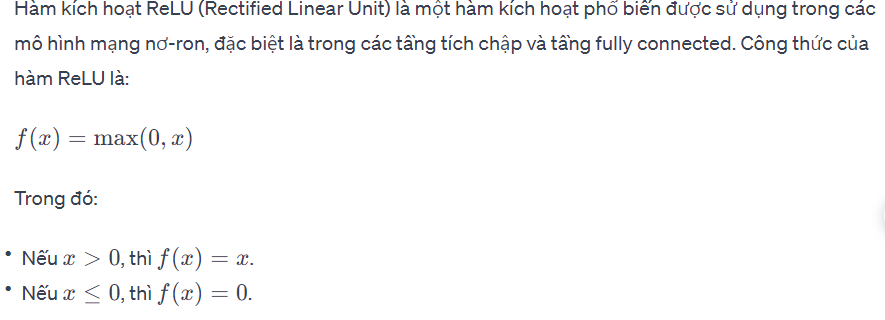

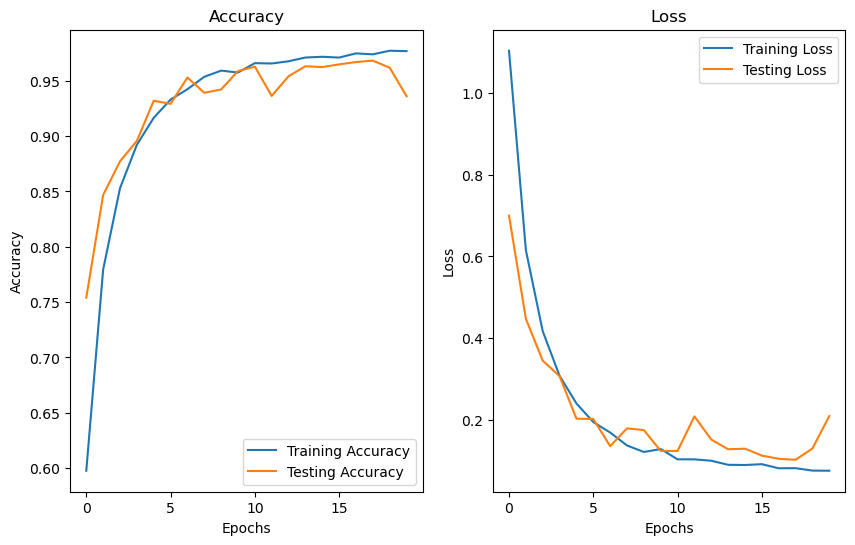

Max Testing Accuracy: 96.83%
Average Testing Accuracy: 93.02%
Final Testing Accuracy: 93.61%


In [3]:
# Lấy giá trị accuracy và loss từ biến "history"
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

max_test_accuracy = max(test_accuracy)
print(f"Max Testing Accuracy: {max_test_accuracy * 100:.2f}%")
# Tính giá trị trung bình của test_accuracy
average_test_accuracy = np.mean(test_accuracy)
# In ra giá trị trung bình
print(f"Average Testing Accuracy: {average_test_accuracy * 100:.2f}%")
final_test_accuracy = test_accuracy[-1]
print(f"Final Testing Accuracy: {final_test_accuracy * 100:.2f}%")

1/1 [==============================] - 0s 36ms/step
Đối tượng này có khả năng thuộc về nhóm 'sung truong' với độ chắc chắn là 100.00%.


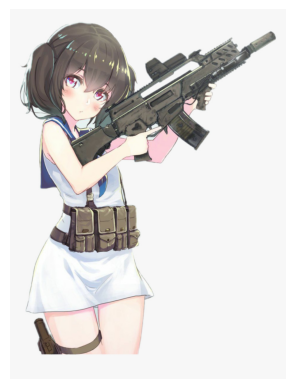

In [13]:
img_path = "C:/Users/Admin/Pictures/sung.jpg"
imgShow = keras.utils.load_img(img_path)
img = keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

prediction = model.predict(img_array)
prediction_probs = prediction[0]

threshold = 0.6

predicted_class = np.argmax(prediction_probs)
max_prob = prediction_probs[predicted_class]
plt.imshow(imgShow)
plt.axis('off')

# Kiểm tra xem đối tượng có thuộc về nhóm nguy hiểm hay không
if max_prob >= threshold:
    class_name = class_names[predicted_class]
    print(
        f"Đối tượng này có khả năng thuộc về nhóm '{class_name}' với độ chắc chắn là {max_prob:.2%}."
    )
else:
    print("Đối tượng có khả năng không gây nguy hiểm với độ chắc chắn dưới ngưỡng.")


1/1 [==============================] - 0s 24ms/step


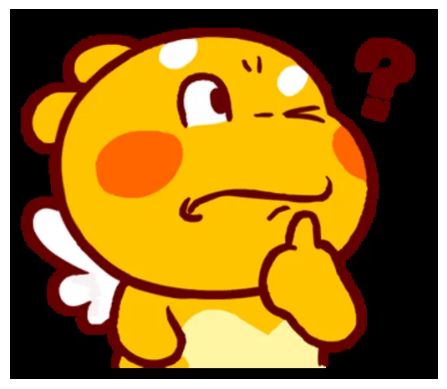

Đối tượng có khả năng không gây nguy hiểm với độ chắc chắn dưới ngưỡng.


In [17]:
img_path = "C:/Users/Admin/Pictures/icon.png"
imgShow = keras.utils.load_img(img_path)
img = keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch


prediction = model.predict(img_array)
# Lấy giá trị độ chắc chắn của tất cả các lớp
prediction_probs = prediction[0]

# Đặt ngưỡng xác định
threshold = 0.6

# Lấy lớp có độ chắc chắn cao nhất
predicted_class = np.argmax(prediction_probs)
max_prob = prediction_probs[predicted_class]
plt.imshow(imgShow)
plt.axis('off')  # Tắt trục
plt.show()

# Kiểm tra xem độ chắc chắn có vượt quá ngưỡng không
if max_prob >= threshold:
    print(
        "Ảnh này có khả năng thuộc về nhóm nguy hiểm với độ chắc chắn là {:.2%}."
        .format(max_prob)
    )
else:
    print("Đối tượng có khả năng không gây nguy hiểm với độ chắc chắn dưới ngưỡng.")